#Capstone Project - Italian Restaurants in Boston

**Introduction**

This project will seek to list and visualize the amazing Italian restaurants in the city of Boston.

**Data**
- Boston neighborhood latitude and longitude information comes from a csv file which was compiled by googling the individual areas.
- Italian restaurant in each neighborhood comes from FourSquare API
- GeoJSON data for Folium map comes from Boston Open Data.


**Approach**
- Collect the Boston data from Boston Open Data using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Italian restaurants.
- Find rating, tips, and like count for each Italian restaurant using FourSquare API.
- Using rating for each restaurant, we will sort that data.
- Visualize the ranking of neighborhoods using folium library(python)

**Questions**

- What area has the most Italian restaurants in Boston?
- Which areas lack Italian restaurants?
- Which areas would be best to visit if you want quality Italian food?

**Import Libraries for Analysis**

- Pandas and Numpy for handling the data
- Request for using FourSquare API
- Geopy to get coordinates of Boston
- Folium to visualize the maps

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium
from geopy.geocoders import Nominatim #covert an address into long and lat values

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print("Libraries imported.")

Libraries imported.


Creating a function to get the geolocation of Boston using geopy.

In [ ]:
def geo_location(address):
  geolocator = Nominatim(user_agent='boston_explorer')
  location = geolocator.geocode(address)
  latitude = location.latitude
  longitude = location.longitude
  return latitude,longitude

Function to interact with FourSquare API to get the top 100 venues within a 1000 meter radius of the coordinates given. The function will return the venue id, venue name, and category

In [ ]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'UVPJD1KMYDMHOOVMIVHD0L1LOAM3Y1YO5SA3N2XC1ALMWY0U' # your Foursquare ID
    CLIENT_SECRET = 'IT1H0TBBXUTOGVOORWEHUZWCAVEWR0PSRZE2QJ5B03OI0QOH' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Function to get venue details like count, rating, tip counts for a given venue id. This will be used for ranking.

In [ ]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'UVPJD1KMYDMHOOVMIVHD0L1LOAM3Y1YO5SA3N2XC1ALMWY0U' # your Foursquare ID
    CLIENT_SECRET = 'IT1H0TBBXUTOGVOORWEHUZWCAVEWR0PSRZE2QJ5B03OI0QOH' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Load the city data of Boston, which includes Neighborhoods and their Latitudes and Longitudes

In [ ]:
file = '/content/drive/My Drive/Colab Notebooks/Coursera Courses/ IBM Data Science Professional Certificate/Applied Data Science Capstone/Boston Neighborhoods.csv'
boston_data = pd.read_csv(file,
                          names = ['Neighborhood', 'Latitude', 'Longitude'])
print(boston_data.shape)
boston_data

(23, 3)


,Neighborhood,Latitude,Longitude
0,Allston,42.358430,-71.125886
1,Back Bay,42.350097,-71.086996
2,Bay Village,42.350653,-71.069773
3,Beacon Hill,42.358708,-71.067829
4,Brighton,42.350097,-71.156442
5,Charlestown,42.377875,-71.061996
6,Chinatown-Leather District,42.350100,-71.062400
7,Dorchester,42.297321,-71.074495
8,Downtown,42.354542,-71.057829
9,East Boston,42.375097,-71.039217


Collecting Italian restaurants for each neighborhood

In [ ]:
# prepare neighborhood list that contains italian restaurants
column_names=['Neighborhood', 'ID','Name']
italian_rest_boston=pd.DataFrame(columns=column_names)
count=1
for row in boston_data.values.tolist():
    Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(boston_data),')','Italian Restaurants in '+Neighborhood+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_boston = italian_rest_boston.append({'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 23 ) Italian Restaurants in Allston:2
( 2 / 23 ) Italian Restaurants in Back Bay:3
( 3 / 23 ) Italian Restaurants in Bay Village:3
( 4 / 23 ) Italian Restaurants in Beacon Hill:5
( 5 / 23 ) Italian Restaurants in Brighton:1
( 6 / 23 ) Italian Restaurants in Charlestown:0
( 7 / 23 ) Italian Restaurants in Chinatown-Leather District:2
( 8 / 23 ) Italian Restaurants in Dorchester:0
( 9 / 23 ) Italian Restaurants in Downtown:5
( 10 / 23 ) Italian Restaurants in East Boston:3
( 11 / 23 ) Italian Restaurants in Fenway-Kenmore:0
( 12 / 23 ) Italian Restaurants in Hyde Park:1
( 13 / 23 ) Italian Restaurants in Jamaica Plain:0
( 14 / 23 ) Italian Restaurants in Mattapan:0
( 15 / 23 ) Italian Restaurants in Mid-Dorchester:0
( 16 / 23 ) Italian Restaurants in Mission Hill:2
( 17 / 23 ) Italian Restaurants in North End:16
( 18 / 23 ) Italian Restaurants in Roslindale:2
( 19 / 23 ) Italian Restaurants in Roxbury:2
( 20 / 23 ) Italian Restaurants in South Boston:2
( 21 / 23 ) Italian Restauran

Analyze the data for all italian restaurants in Boston

In [ ]:
print(italian_rest_boston.shape)
italian_rest_boston.head()

(59, 3)


,Neighborhood,ID,Name
0,Allston,4a8de631f964a520581120e3,Carlo's Cucina Italiana
1,Allston,4a2dc382f964a520ee971fe3,Alfredo's
2,Back Bay,592b76f6d0a1495f69d7b1da,La Pizza & La Pasta
3,Back Bay,583e3185a36ecd1d8734e2e2,La Piazza at Eataly
4,Back Bay,4a8583f7f964a52060fe1fe3,Sorellina


There are 59 restaurants in Boston.

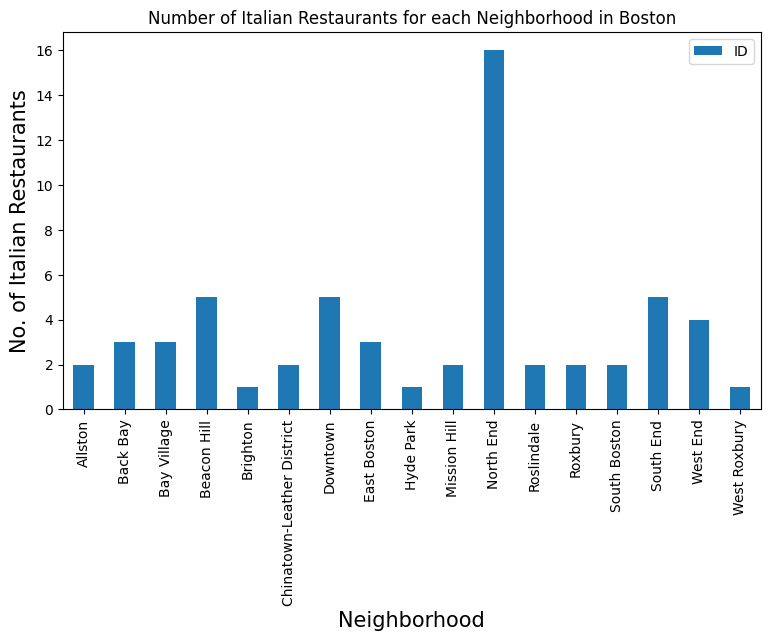

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Neighborhood in Boston')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No. of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_boston.groupby('Neighborhood')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is clear that the North End has the largest number of Italian restaurants by at least a factor of 3.

Now we will rank each Italian restaurant in Boston.

In [ ]:
# prepare neighborhood list that contains italian resturants
column_names=['Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
italian_rest_stats_boston=pd.DataFrame(columns=column_names)
count=1

for row in italian_rest_boston.values.tolist():
    Neighborhood, ID, Name = row
    try:
      venue_details = get_venue_details(ID)
      print(venue_details)
      id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        # recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_boston),')','processed')
    italian_rest_stats_boston = italian_rest_stats_boston.append({'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                     Name  Likes  Rating  Tips
0  4a8de631f964a520581120e3  Carlo's Cucina Italiana     51     8.1    29
( 1 / 59 ) processed
                         ID       Name  Likes  Rating  Tips
0  4a2dc382f964a520ee971fe3  Alfredo's      5     6.4     5
( 2 / 59 ) processed
                         ID                 Name  Likes  Rating  Tips
0  592b76f6d0a1495f69d7b1da  La Pizza & La Pasta     38     8.9     4
( 3 / 59 ) processed
                         ID                 Name  Likes  Rating  Tips
0  583e3185a36ecd1d8734e2e2  La Piazza at Eataly     13     8.1     2
( 4 / 59 ) processed
                         ID       Name  Likes  Rating  Tips
0  4a8583f7f964a52060fe1fe3  Sorellina    116     8.9    63
( 5 / 59 ) processed
                         ID     Name  Likes  Rating  Tips
0  5568f89f498e12c9d5dc83ea  davio's     64     8.4    11
( 6 / 59 ) processed
                         ID       Name  Likes  Rating  Tips
0  4a8583f7f964a52060fe1fe3  S

In [ ]:
italian_rest_stats_boston

NameError: ignored

Converting the "Likes" and "Tips" from strings to floats

In [ ]:
italian_rest_stats_boston['Likes'] = italian_rest_stats_boston['Likes'].astype('float64')
italian_rest_stats_boston['Tips'] = italian_rest_stats_boston['Tips'].astype('float64')

Check that the conversion happened

In [ ]:
italian_rest_stats_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  59 non-null     object 
 1   ID            59 non-null     object 
 2   Name          59 non-null     object 
 3   Likes         59 non-null     float64
 4   Rating        59 non-null     float64
 5   Tips          59 non-null     float64
dtypes: float64(3), object(3)
memory usage: 2.9+ KB


Group neighborhoods by average italian restaurant ratings

In [ ]:
boston_neighborhood_stats = italian_rest_stats_boston.groupby('Neighborhood', as_index=False).mean()[['Neighborhood', 'Rating']]
boston_neighborhood_stats.columns = ['Neighborhood', 'Avg Rating']
boston_neighborhood_stats.sort_values(['Avg Rating'], ascending=False)

,Neighborhood,Avg Rating
2,Bay Village,8.766667
14,South End,8.760000
1,Back Bay,8.633333
13,South Boston,8.600000
11,Roslindale,8.450000
15,West End,8.325000
3,Beacon Hill,8.300000
6,Downtown,8.240000
10,North End,8.225000
5,Chinatown-Leather District,8.200000


Visualizing the above data

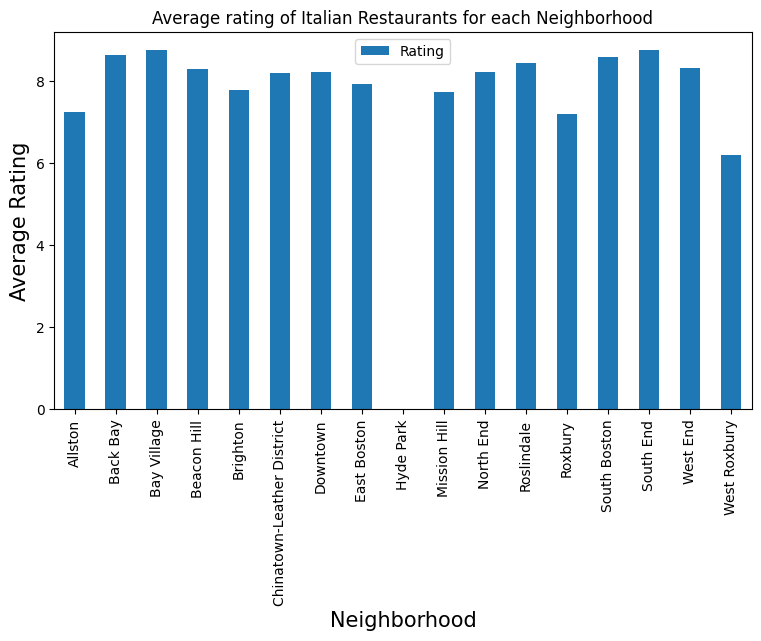

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Restaurants for each Neighborhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_boston.groupby('Neighborhood').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Considering neighborhoods with an average rating greater than or equal to 8.25

In [ ]:
boston_neighborhood_stats = boston_neighborhood_stats[boston_neighborhood_stats['Avg Rating']>=8.0]
boston_neighborhood_stats

,Neighborhood,Avg Rating
1,Back Bay,8.633333
2,Bay Village,8.766667
3,Beacon Hill,8.300000
5,Chinatown-Leather District,8.200000
6,Downtown,8.240000
10,North End,8.225000
11,Roslindale,8.450000
13,South Boston,8.600000
14,South End,8.760000
15,West End,8.325000


Joining the above dataset with the original Boston data

In [ ]:
boston_neighborhood_stats = pd.merge(boston_neighborhood_stats, boston_data, on = 'Neighborhood')

In [ ]:
boston_neighborhood_stats=boston_neighborhood_stats[['Neighborhood', 'Latitude', 'Longitude', 'Avg Rating']]

In [ ]:
boston_neighborhood_stats['Avg Rating']= boston_neighborhood_stats['Avg Rating'].round(decimals=3)

In [ ]:
boston_neighborhood_stats

,Neighborhood,Latitude,Longitude,Avg Rating
0,Back Bay,42.350097,-71.086996,8.633
1,Bay Village,42.350653,-71.069773,8.767
2,Beacon Hill,42.358708,-71.067829,8.300
3,Chinatown-Leather District,42.350100,-71.062400,8.200
4,Downtown,42.354542,-71.057829,8.240
5,North End,42.365097,-71.054495,8.225
6,Roslindale,42.291209,-71.124497,8.450
7,South Boston,42.333431,-71.049495,8.600
8,South End,42.338800,-71.076500,8.760
9,West End,42.364400,-71.066100,8.325


Creating a map with Folium to display the results

In [ ]:
boston_map = folium.Map(location=geo_location('Boston'), zoom_start=12)

In [ ]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in boston_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Adding fields to dataframe for labels

In [ ]:
boston_neighborhood_stats['Label']=boston_neighborhood_stats['Neighborhood']+', ('+boston_neighborhood_stats['Avg Rating'].map(str)+')'


In [ ]:
# add pop-up text to each marker on the map
for lat, lng, label in boston_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(boston_map)        
# add incidents to map
boston_map.add_child(incidents)



Visualizing neighborhoods based on average rating

In [ ]:
boston_neighborhood_stats

,Neighborhood,Latitude,Longitude,Avg Rating,Label
0,Back Bay,42.350097,-71.086996,8.633,"Back Bay, (8.633)"
1,Bay Village,42.350653,-71.069773,8.767,"Bay Village, (8.767)"
2,Beacon Hill,42.358708,-71.067829,8.300,"Beacon Hill, (8.3)"
3,Chinatown-Leather District,42.350100,-71.062400,8.200,"Chinatown-Leather District, (8.2)"
4,Downtown,42.354542,-71.057829,8.240,"Downtown, (8.24)"
5,North End,42.365097,-71.054495,8.225,"North End, (8.225)"
6,Roslindale,42.291209,-71.124497,8.450,"Roslindale, (8.45)"
7,South Boston,42.333431,-71.049495,8.600,"South Boston, (8.6)"
8,South End,42.338800,-71.076500,8.760,"South End, (8.76)"
9,West End,42.364400,-71.066100,8.325,"West End, (8.325)"


In [ ]:
boston_map = folium.Map(location=geo_location('Boston'), zoom_start=12)
boston_geo = 'https://opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson'

folium.Choropleth(
    geo_data=boston_geo,
    name='choropleth',
    data=boston_neighborhood_stats,
    columns=['Neighborhood', 'Avg Rating'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.5,
    legend_name='Average Rating',
    highlight=True
).add_to(boston_map)

folium.LayerControl().add_to(boston_map)

#display map
boston_map

![alt text](https://drive.google.com/uc?id=1hJqUSFFBM5L0mmsYxWiNp18a2jrVwQHO)

**Conclusion**
- The North End has the overwhelming majority of Italian restaurants in Boston.
- However, Bay Village, South End, and Back Bay have the highest ratings.
- For quantity of Italian food, one should stay in the North End.
- For quality of Italian food, one should stay in the southwest area of the Bay Village.